In [1]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator

from inxss import SpectrumDataset, SpecNeuralRepr, Particle, PsiMask, OnlineVariance, linspace_2D_equidistant
from inxss.utils_visualization import arc_arrow, rad_arrow

import matplotlib.pyplot as plt

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

torch.set_default_dtype(torch.float32)

In [2]:
from inxss.experiment import NeutronExperiment, SimulatedExperiment

In [3]:
data = torch.load('/pscratch/sd/z/zhantao/inxs_steering/experiment_data/summarized_neutron_data_w_bkg_260meV.pt')
print(data.keys())

dict_keys(['grid', 'S', 'background', 'scale', 'scale_separator'])


### setup experiment simulator

In [4]:
from inxss.experiment import Background

In [5]:
background = Background(
    tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]), 
    data['grid']['w_grid'], 
    data['background'], 
    data['scale'],
    data['scale_separator']
)

In [6]:
background.scale_separator

{'inner_mid': 1.1441, 'mid_outer': 1.8512}

In [7]:
background.scale['inner']['scale_mask'].shape

torch.Size([121, 121, 30, 66])

### Testing integrated steer module

In [8]:
from inxss.steer_neutron import NeutronExperimentSteerer

In [9]:
particle_filter_config = {
    "num_particles": 500,
    "dim_particles": 2,
    "prior_configs": {'types': ['uniform', 'uniform'], 'args': [{'low': 20, 'high': 40}, {'low': -5, 'high': 5}]}
}


grid_info = {
    'h_grid': [-2.0, 2.0, 121],
    'k_grid': [-2.0, 2.0, 121],
    'l_grid': [-10.0, 4.5, 30],
    'w_grid': [20.0, 150.0, 66]
}
# grid_info = {
#     _: [eval(f'neutron_exp.{_}').min().item(), eval(f'neutron_exp.{_}').max().item(), eval(f'neutron_exp.{_}').shape[0]] 
#     for _ in ['h_grid', 'k_grid', 'l_grid', 'w_grid']}

mask_config = {
    "raw_mask_path": '/pscratch/sd/z/zhantao/inxs_steering/La2NiO4_bool',
    "memmap_mask_path": '/pscratch/sd/z/zhantao/inxs_steering/mask_data',
    "grid_info": grid_info,
    "preload": False,
    "build_from_scratch_if_no_memmap": False,
    "global_mask": data['S']>0
}

experiment_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "S_grid": data['S'],
    "S_scale_factor": 1.
}

background_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "bkg_grid": data['background'],
    "scale": data['scale'],
    "scale_separator": data['scale_separator']
}

model = SpecNeuralRepr.load_from_checkpoint(
    '/pscratch/sd/z/zhantao/inxs_steering/lightning_logs/version_14896843/checkpoints/epoch=1165-step=55968.ckpt'
    ).to(device)

steer = NeutronExperimentSteerer(
    model, particle_filter_config=particle_filter_config, 
    mask_config=mask_config, experiment_config=experiment_config, background_config=background_config,
    likelihood_sample_ratio=0.2, tqdm_pbar=False, device='cuda')

obtained memmap mask name as: mask_h_-2.0_2.0_121_k_-2.0_2.0_121_l_-10.0_4.5_30_w_20.0_150.0_66.npy


In [12]:
mean_list = []
std_list = []
steer.reset()

In [15]:
# print(data['params'][test_idx[idx_plot]])
with torch.no_grad():
    print(steer.particle_filter.mean().detach().cpu(), steer.particle_filter.std().detach().cpu()) 
    for i in tqdm(range(50)):
        steer.step_steer()
        print(steer.particle_filter.mean(), steer.particle_filter.std())
        mean_list.append(steer.particle_filter.mean().detach().cpu())
        std_list.append(steer.particle_filter.std().detach().cpu())
    
    # print(steer.particle_filter.positions[:10])
    # print(steer.particle_filter.weights[:10])

tensor([27.4600,  1.0118], dtype=torch.float64) tensor([3.5295, 2.3449], dtype=torch.float64)


  2%|▏         | 1/50 [00:07<05:49,  7.13s/it]

tensor([27.6942,  1.0964], dtype=torch.float64) tensor([3.4901, 2.3280], dtype=torch.float64)


  4%|▍         | 2/50 [00:14<05:43,  7.15s/it]

tensor([27.6923,  1.0486], dtype=torch.float64) tensor([3.4445, 2.3233], dtype=torch.float64)


  6%|▌         | 3/50 [00:21<05:34,  7.13s/it]

tensor([27.7166,  1.0283], dtype=torch.float64) tensor([3.4100, 2.3027], dtype=torch.float64)


  8%|▊         | 4/50 [00:28<05:27,  7.12s/it]

tensor([27.8583,  1.1259], dtype=torch.float64) tensor([3.3472, 2.2664], dtype=torch.float64)


 10%|█         | 5/50 [00:35<05:21,  7.15s/it]

tensor([27.9755,  1.2209], dtype=torch.float64) tensor([3.2779, 2.2197], dtype=torch.float64)


 12%|█▏        | 6/50 [00:42<05:13,  7.13s/it]

tensor([27.9714,  1.2094], dtype=torch.float64) tensor([3.2266, 2.1945], dtype=torch.float64)


 14%|█▍        | 7/50 [00:49<05:06,  7.12s/it]

tensor([27.9697,  1.2084], dtype=torch.float64) tensor([3.2249, 2.1940], dtype=torch.float64)


 16%|█▌        | 8/50 [00:57<04:58,  7.12s/it]

tensor([28.0537,  1.2753], dtype=torch.float64) tensor([3.2041, 2.1712], dtype=torch.float64)


 18%|█▊        | 9/50 [01:04<04:51,  7.11s/it]

tensor([28.0727,  1.2580], dtype=torch.float64) tensor([3.1167, 2.1387], dtype=torch.float64)


 20%|██        | 10/50 [01:11<04:45,  7.14s/it]

tensor([28.1453,  1.2967], dtype=torch.float64) tensor([3.0833, 2.1216], dtype=torch.float64)


 22%|██▏       | 11/50 [01:18<04:42,  7.25s/it]

tensor([28.2594,  1.3655], dtype=torch.float64) tensor([3.0053, 2.0665], dtype=torch.float64)


 24%|██▍       | 12/50 [01:25<04:33,  7.20s/it]

tensor([28.2330,  1.3457], dtype=torch.float64) tensor([2.9722, 2.0502], dtype=torch.float64)


 26%|██▌       | 13/50 [01:33<04:25,  7.17s/it]

tensor([28.2233,  1.3415], dtype=torch.float64) tensor([2.9207, 2.0107], dtype=torch.float64)


 28%|██▊       | 14/50 [01:40<04:18,  7.17s/it]

tensor([28.3637,  1.4527], dtype=torch.float64) tensor([2.8459, 1.9516], dtype=torch.float64)


 30%|███       | 15/50 [01:47<04:11,  7.18s/it]

tensor([28.4164,  1.4952], dtype=torch.float64) tensor([2.8923, 1.9823], dtype=torch.float64)


 32%|███▏      | 16/50 [01:54<04:03,  7.17s/it]

tensor([28.1895,  1.4153], dtype=torch.float64) tensor([2.7566, 1.9138], dtype=torch.float64)


 34%|███▍      | 17/50 [02:02<04:06,  7.46s/it]

tensor([28.2672,  1.4316], dtype=torch.float64) tensor([2.6162, 1.8208], dtype=torch.float64)


 36%|███▌      | 18/50 [02:09<03:56,  7.40s/it]

tensor([28.4400,  1.5608], dtype=torch.float64) tensor([2.4505, 1.6900], dtype=torch.float64)


 38%|███▊      | 19/50 [02:17<03:46,  7.31s/it]

tensor([28.4138,  1.5067], dtype=torch.float64) tensor([2.3633, 1.6255], dtype=torch.float64)


 40%|████      | 20/50 [02:24<03:38,  7.27s/it]

tensor([28.5471,  1.5786], dtype=torch.float64) tensor([2.2754, 1.5797], dtype=torch.float64)


 42%|████▏     | 21/50 [02:31<03:31,  7.28s/it]

tensor([28.4293,  1.4989], dtype=torch.float64) tensor([2.1989, 1.5298], dtype=torch.float64)


 44%|████▍     | 22/50 [02:38<03:22,  7.23s/it]

tensor([28.5508,  1.5759], dtype=torch.float64) tensor([2.1444, 1.4896], dtype=torch.float64)


 46%|████▌     | 23/50 [02:45<03:14,  7.19s/it]

tensor([28.6235,  1.6129], dtype=torch.float64) tensor([2.0867, 1.4522], dtype=torch.float64)


 48%|████▊     | 24/50 [02:52<03:06,  7.16s/it]

tensor([28.6314,  1.6074], dtype=torch.float64) tensor([2.0436, 1.4269], dtype=torch.float64)


 50%|█████     | 25/50 [02:59<02:58,  7.14s/it]

tensor([28.6013,  1.5830], dtype=torch.float64) tensor([1.9976, 1.3985], dtype=torch.float64)


 52%|█████▏    | 26/50 [03:06<02:51,  7.13s/it]

tensor([28.5988,  1.5849], dtype=torch.float64) tensor([1.9368, 1.3584], dtype=torch.float64)


 54%|█████▍    | 27/50 [03:14<02:44,  7.14s/it]

tensor([28.8776,  1.7908], dtype=torch.float64) tensor([1.8626, 1.2980], dtype=torch.float64)


 56%|█████▌    | 28/50 [03:21<02:37,  7.14s/it]

tensor([28.8901,  1.7971], dtype=torch.float64) tensor([1.7996, 1.2584], dtype=torch.float64)


 58%|█████▊    | 29/50 [03:28<02:29,  7.13s/it]

tensor([28.7127,  1.6874], dtype=torch.float64) tensor([1.6856, 1.1860], dtype=torch.float64)
tensor([28.8204,  1.7452], dtype=torch.float64) tensor([1.7617, 1.2255], dtype=torch.float64)


 62%|██████▏   | 31/50 [03:43<02:19,  7.37s/it]

tensor([28.9335,  1.7728], dtype=torch.float64) tensor([1.7216, 1.1924], dtype=torch.float64)


 64%|██████▍   | 32/50 [03:50<02:11,  7.31s/it]

tensor([28.6097,  1.5228], dtype=torch.float64) tensor([1.5737, 1.0905], dtype=torch.float64)


 66%|██████▌   | 33/50 [03:57<02:03,  7.27s/it]

tensor([28.5834,  1.4925], dtype=torch.float64) tensor([1.4573, 1.0187], dtype=torch.float64)


 68%|██████▊   | 34/50 [04:05<01:55,  7.24s/it]

tensor([28.6019,  1.4899], dtype=torch.float64) tensor([1.4005, 0.9853], dtype=torch.float64)


 70%|███████   | 35/50 [04:12<01:47,  7.19s/it]

tensor([28.7427,  1.5948], dtype=torch.float64) tensor([1.3315, 0.9339], dtype=torch.float64)


 72%|███████▏  | 36/50 [04:19<01:40,  7.17s/it]

tensor([28.5233,  1.4456], dtype=torch.float64) tensor([1.2342, 0.8720], dtype=torch.float64)


 74%|███████▍  | 37/50 [04:26<01:33,  7.16s/it]

tensor([28.4726,  1.4219], dtype=torch.float64) tensor([1.1830, 0.8410], dtype=torch.float64)


 76%|███████▌  | 38/50 [04:33<01:25,  7.15s/it]

tensor([28.4791,  1.4039], dtype=torch.float64) tensor([1.1584, 0.8247], dtype=torch.float64)


 78%|███████▊  | 39/50 [04:40<01:18,  7.14s/it]

tensor([28.5333,  1.4319], dtype=torch.float64) tensor([1.1280, 0.8025], dtype=torch.float64)


 80%|████████  | 40/50 [04:47<01:11,  7.12s/it]

tensor([28.4358,  1.3650], dtype=torch.float64) tensor([1.0812, 0.7714], dtype=torch.float64)


 82%|████████▏ | 41/50 [04:54<01:04,  7.12s/it]

tensor([28.5362,  1.4451], dtype=torch.float64) tensor([1.0570, 0.7525], dtype=torch.float64)


 84%|████████▍ | 42/50 [05:03<00:59,  7.42s/it]

tensor([28.5374,  1.4461], dtype=torch.float64) tensor([1.0568, 0.7523], dtype=torch.float64)


 86%|████████▌ | 43/50 [05:10<00:52,  7.51s/it]

tensor([28.6328,  1.5179], dtype=torch.float64) tensor([1.0316, 0.7330], dtype=torch.float64)


 88%|████████▊ | 44/50 [05:18<00:44,  7.44s/it]

tensor([28.5721,  1.4787], dtype=torch.float64) tensor([0.9503, 0.6735], dtype=torch.float64)


 90%|█████████ | 45/50 [05:25<00:36,  7.35s/it]

tensor([28.6909,  1.5666], dtype=torch.float64) tensor([0.8926, 0.6302], dtype=torch.float64)


 92%|█████████▏| 46/50 [05:32<00:29,  7.28s/it]

tensor([28.8052,  1.6685], dtype=torch.float64) tensor([0.8588, 0.5969], dtype=torch.float64)


 94%|█████████▍| 47/50 [05:39<00:21,  7.23s/it]

tensor([28.8849,  1.7303], dtype=torch.float64) tensor([0.8123, 0.5662], dtype=torch.float64)


 96%|█████████▌| 48/50 [05:46<00:14,  7.25s/it]

tensor([28.9437,  1.7780], dtype=torch.float64) tensor([0.7897, 0.5457], dtype=torch.float64)


 98%|█████████▊| 49/50 [05:53<00:07,  7.21s/it]

tensor([29.0087,  1.7926], dtype=torch.float64) tensor([0.7806, 0.5382], dtype=torch.float64)


100%|██████████| 50/50 [06:00<00:00,  7.22s/it]

tensor([28.9607,  1.7952], dtype=torch.float64) tensor([0.7524, 0.5197], dtype=torch.float64)


In [16]:
means = torch.vstack(mean_list).detach().numpy()[:]
std_dev = torch.vstack(std_list).detach().numpy()[:]

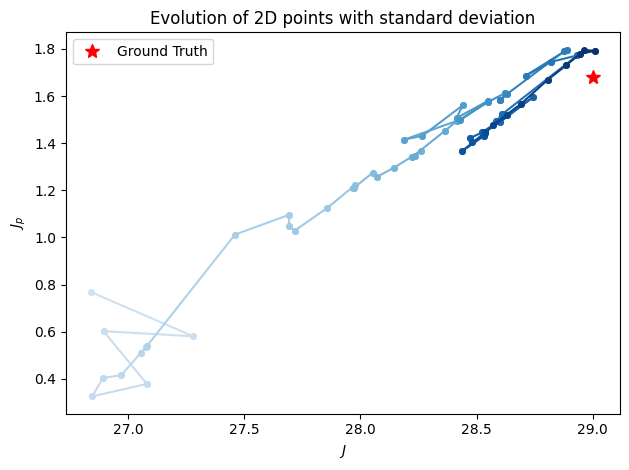

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create some dummy data
scale_factor = 0.25
N = means.shape[0]
# means = np.cumsum(np.random.randn(N, 2), axis=0)
# stds = np.abs(np.random.randn(N, 2))

# Visualization
fig, ax = plt.subplots()

cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0.2, 1, N)]

# Plot the evolution of the points with colormap
for i in range(N-1):
    ax.plot(means[i:i+2, 0], means[i:i+2, 1], '-o', color=colors[i], markersize=4)


# # Plot ovals for standard deviation
# for i in range(N):
#     ellipse = patches.Ellipse((means[i, 0], means[i, 1]),
#                               width=std_dev[i, 0]*scale_factor,  
#                               height=std_dev[i, 1]*scale_factor,
#                               edgecolor=None, facecolor=colors[i], alpha=0.2)  
#     ax.add_patch(ellipse)

ax.plot(29.0, 1.68, '*', label='Ground Truth', markersize=10, color='red')

ax.set_title('Evolution of 2D points with standard deviation')
ax.set_xlabel('$J$')
ax.set_ylabel('$J_{p}$')
# ax.set_xlim(20, 40)
# ax.set_ylim(-5, 5)
ax.legend()

plt.tight_layout()
plt.show()
